In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from skimage import io, color, img_as_bool, exposure, transform, feature
from skimage import data
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.transform import warp, AffineTransform
from skimage.draw import ellipse
from sklearn.linear_model import Perceptron
from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction
%matplotlib inline

In [5]:
# file paths
path = '/Users/marcinia/Downloads/ml-master/final_assignment_2/plane_data/full_images/'
f = '/Users/marcinia/Downloads/ml-master/final_assignment_2/plane_data/plane_labels.csv'

(360, 640, 4)


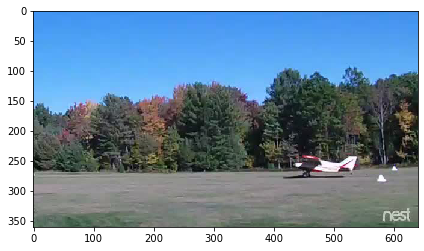

In [6]:
img_raw = io.imread('2016-10-10T19+44+49_610Z')
print(img_raw.shape)
io.imshow(img_raw)


In [7]:
# all labels
plane_data = pd.read_csv(f)
print(plane_data.head())
print(plane_data.shape)

                   img_name  plane
0  2016-08-02T13+50+24_430Z  False
1  2016-08-02T14+12+37_390Z  False
2  2016-08-02T22+20+26_600Z  False
3  2016-08-03T12+04+30_670Z  False
4  2016-08-03T12+32+21_790Z  False
(6758, 2)


In [8]:
# filter to include only the airplane images
print(plane_data['plane'].sum())
aircraft = plane_data[plane_data['plane']==True]
print(aircraft.shape)

101
(101, 2)


In [9]:
# take a random subset of 20 of the airplane images
aircraft_subset = aircraft.sample(20)
print(aircraft_subset.shape)

(20, 2)


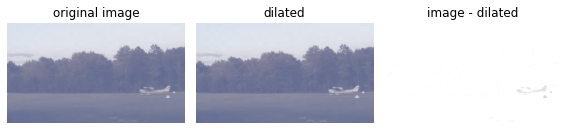

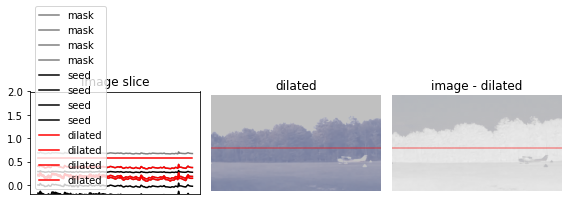

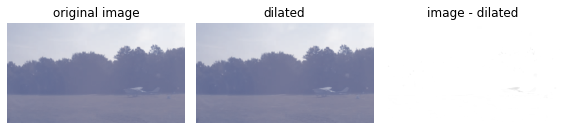

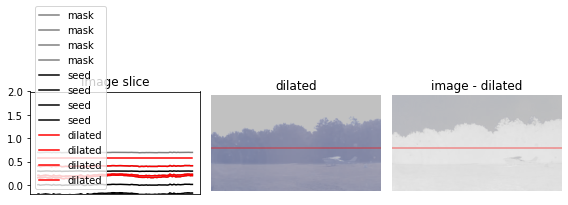

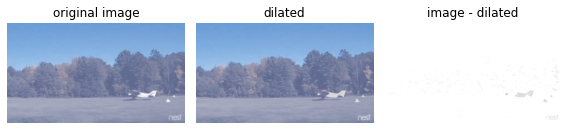

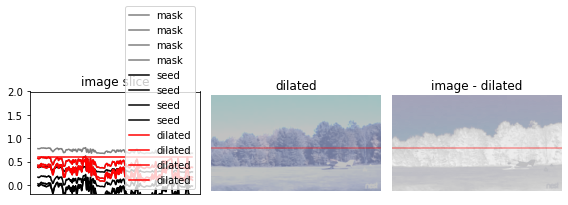

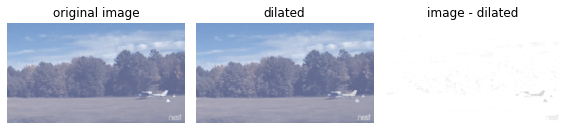

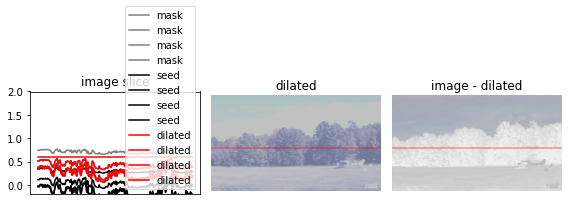

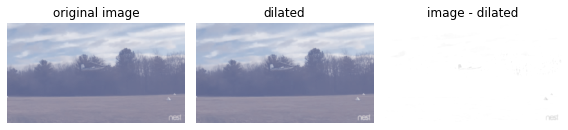

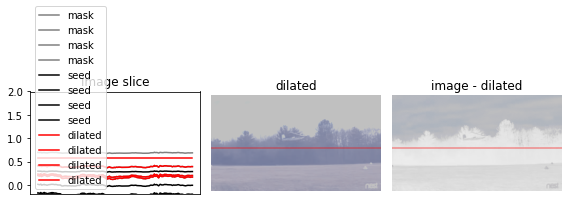

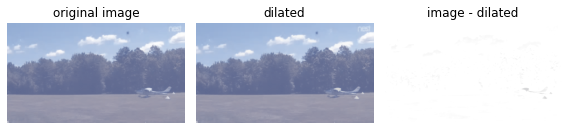

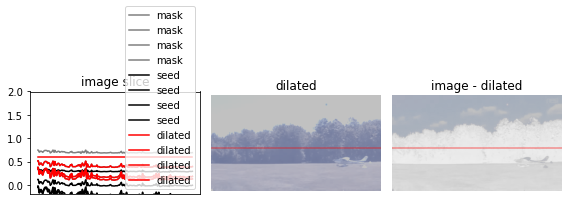

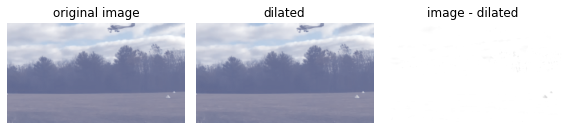

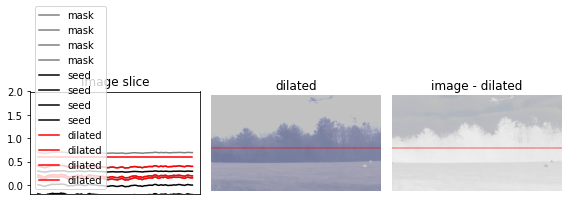

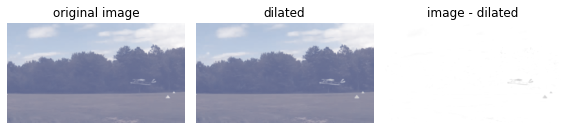

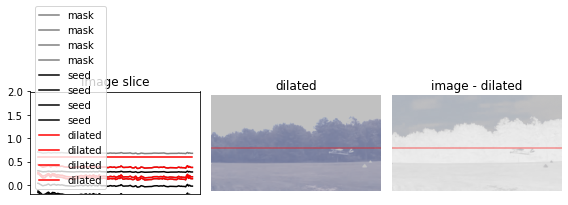

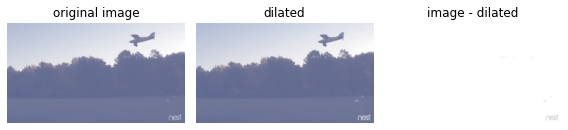

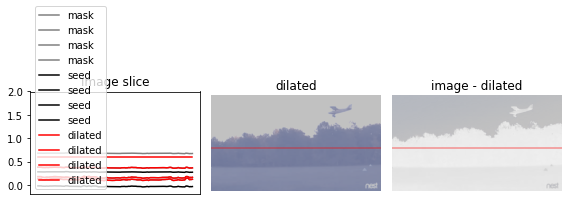

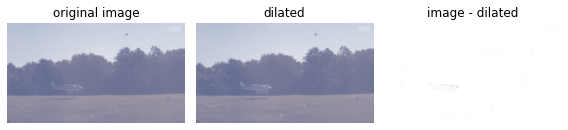

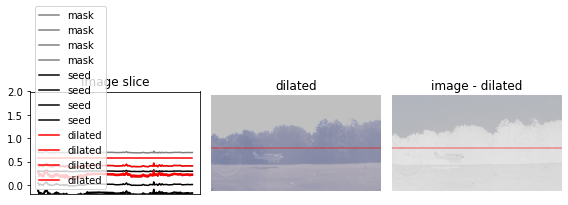

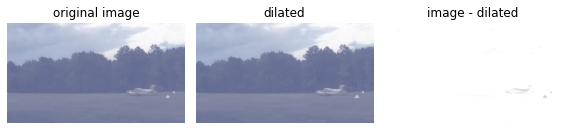

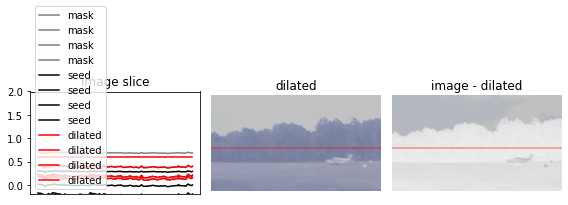

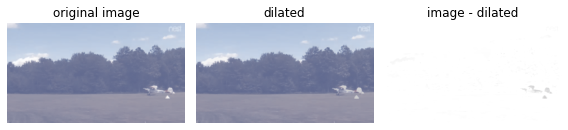

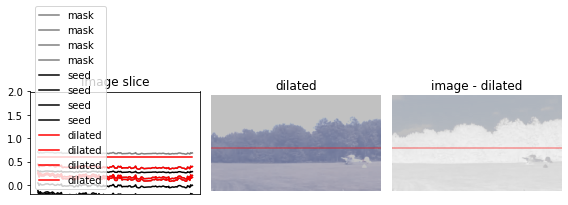

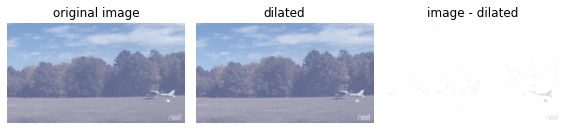

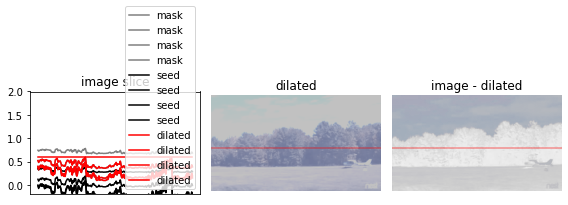

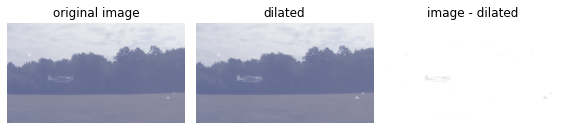

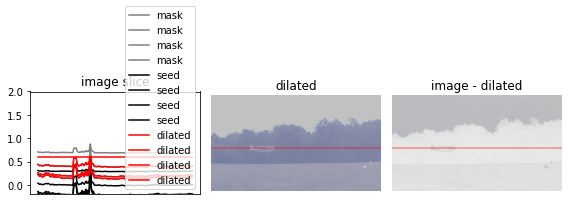

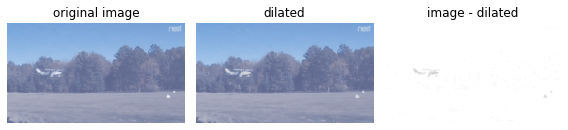

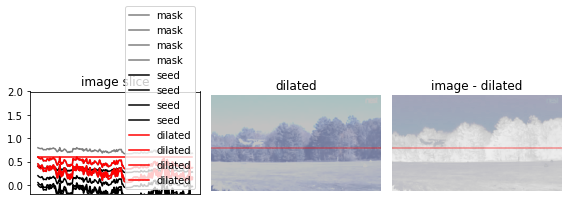

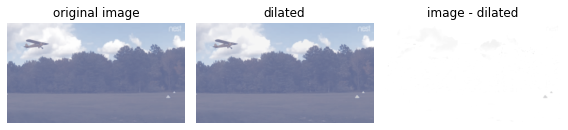

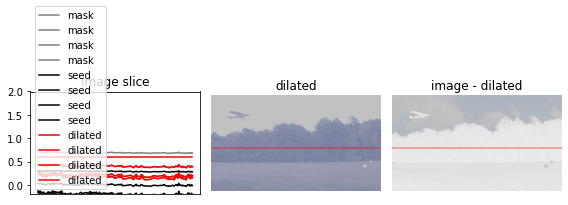

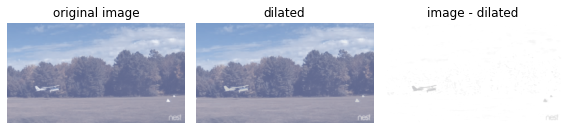

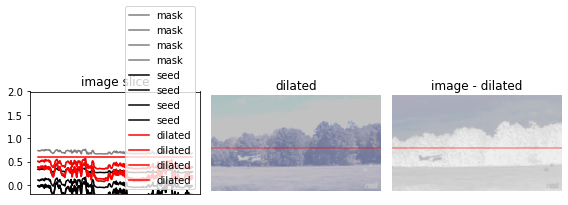

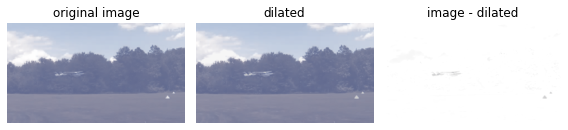

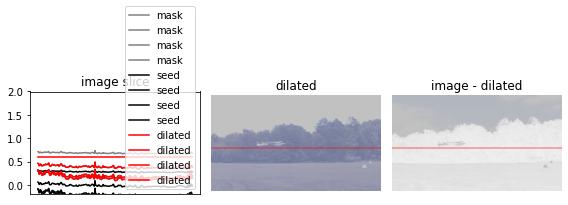

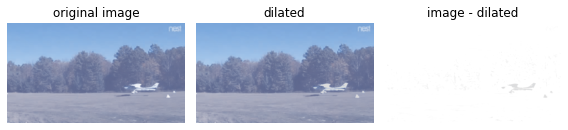

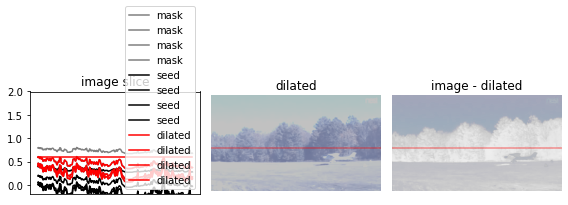

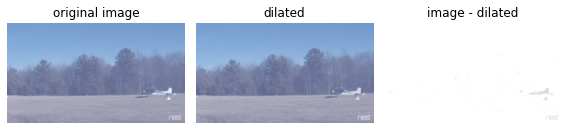

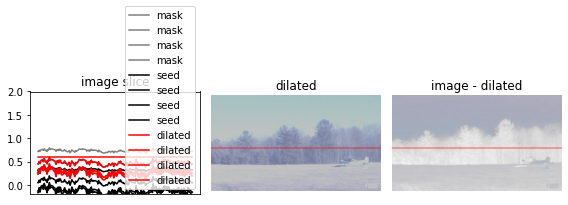

In [23]:

for index, row in aircraft_subset.iterrows():
    imname = path + row['img_name'] + '.png'
    img_raw = io.imread(imname) # <- is an nd array 

    img_raw = img_as_float(img_raw)
    img_raw = gaussian_filter(img_raw, 1)

    seed = np.copy(img_raw)
    seed[1:-1, 1:-1] = img_raw.min()
    mask = img_raw

    dilated = reconstruction(seed, mask, method='dilation')    

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=3,
                                        figsize=(8, 2.5),
                                        sharex=True,
                                        sharey=True)

    ax0.imshow(img_raw, cmap='gray')
    ax0.set_title('original image')
    ax0.axis('off')

    ax1.imshow(dilated, vmin=img_raw.min(), vmax=img_raw.max(), cmap='gray')
    ax1.set_title('dilated')
    ax1.axis('off')

    ax2.imshow(img_raw - dilated, cmap='gray')
    ax2.set_title('image - dilated')
    ax2.axis('off')

    fig.tight_layout()

    h = 0.4
    seed = img_raw - h
    dilated = reconstruction(seed, mask, method='dilation')
    hdome = img_raw - dilated

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(8, 2.5))
    yslice = 197

    ax0.plot(mask[yslice], '0.5', label='mask')
    ax0.plot(seed[yslice], 'k', label='seed')
    ax0.plot(dilated[yslice], 'r', label='dilated')
    ax0.set_ylim(-0.2, 2)
    ax0.set_title('image slice')
    ax0.set_xticks([])
    ax0.legend()

    ax1.imshow(dilated, vmin=img_raw.min(), vmax=img_raw.max(), cmap='gray')
    ax1.axhline(yslice, color='r', alpha=0.4)
    ax1.set_title('dilated')
    ax1.axis('off')

    ax2.imshow(hdome, cmap='gray')
    ax2.axhline(yslice, color='r', alpha=0.4)
    ax2.set_title('image - dilated')
    ax2.axis('off')

    fig.tight_layout()
    plt.show()
 
        




/Users/marcinia/Downloads/ml-master/final_assignment_2/plane_data/full_images/2017-08-25T23+24+13_390Z.png
downscaled image shape: 
(15, 35)


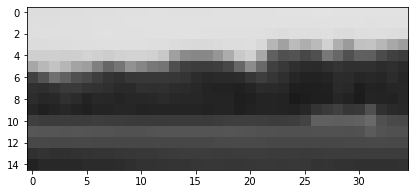

In [59]:
dims = (15, 35) # 25% of the original size, 525 pixels

def image_manipulation(imname, imgs_path, imview=False):
   # warnings.filterwarnings('ignore')
    imname = imgs_path + imname + '.png'
    print(imname)
    img = io.imread(imname, as_gray=True)
    downscaled = transform.resize(img, (dims[0], dims[1])) # downscale image
    final_image = (downscaled)
    if imview==True:
        io.imshow(final_image)
    return final_image


# test the function, look at input/output
test_image = image_manipulation('2017-08-25T23+24+13_390Z', path, True)
print('downscaled image shape: ')
print(test_image.shape)
#print('image representation (first row of pixels): ')
#print(test_image[0])
#print('\n')
#print('example of transformation: ')

In [16]:
# function that takes raw images and completes all preprocessing required before model fits
def process_raw_data(labels_fn, images_fp, my_random_seed, imview=False, test=False):
    plane_data = aircraft_subset # read in photograph labels
    print("First few lines of image labels: ")
    print(plane_data.head())
    print("Size of image label dataFrame: ")
    print(plane_data.shape)
        
    # construct lists for features, labels, and a crosswalk reference to image names
    features_list = []
    if (not test):
        y_list = []
    imnames_list = []

    for index, row in plane_data.iterrows():
        features_list.append(image_manipulation(row['img_name'], images_fp))
        if (not test):
            y_list.append(row['plane'])
        imnames_list.append(row['img_name'])
    
    # convert the lists to ndarrays
    features = np.asarray(features_list)
    if (not test):
        Y = np.asarray(y_list)
    imgs = np.asarray(imnames_list)
    print('Shape of original feature representation: ')
    print(features.shape)

    # flatten the images ndarray to one row per image
    features_flat = features.reshape((features.shape[0], -1))

    print('Shape of flat feature representation: ')
    print(features_flat.shape)

    if (not test):
        print('Shape of Y: ')
        print(Y.shape)

        print('Number of images with planes: ')
        print(Y.sum())
    
        # create train and test sets
        data_train, data_test, y_train, y_test, imgs_train, imgs_test = train_test_split(features_flat, 
            Y, imgs, test_size = 0.25, random_state = my_random_seed)

        print('Shape of training set: ')
        print(y_train.shape)
        print('Number of training images that contain an airplane: ')
        print(y_train.sum())

        print('Shape of test set: ')
        print(y_test.shape)
        print('Number of test images that contain an airplane: ')
        print(y_test.sum())
    
    if (test):
        X_submission_test = features_flat
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(X_submission_test, plane_data)
    else: 
        print("Shape of data_train and data_test:")
        print(data_train.shape)
        print(data_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of imgs_train and imgs_test:")
        print(imgs_train.shape)
        print(imgs_test.shape)
        print('SUCCESS!')
        return(data_train, data_test, y_train, y_test, imgs_train, imgs_test)


In [17]:
data_train, data_test, y_train, y_test, imgs_train, imgs_test = process_raw_data(f, path, 
    my_random_seed=81, imview=False, test=False)

First few lines of image labels: 
                   img_name  plane
0  2016-08-02T13+50+24_430Z  False
1  2016-08-02T14+12+37_390Z  False
2  2016-08-02T22+20+26_600Z  False
3  2016-08-03T12+04+30_670Z  False
4  2016-08-03T12+32+21_790Z  False
Size of image label dataFrame: 
(6758, 2)


AttributeError: 'AxesSubplot' object has no attribute 'shape'

In [ ]:
# MODEL: Perceptron
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(data_train, y_train)

prc_performance = BinaryClassificationPerformance(prc.predict(data_train), y_train, 'prc')
prc_performance.compute_measures()
prc_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(prc_performance.performance_measures)

prc_performance_test = BinaryClassificationPerformance(prc.predict(data_test), y_test, 'prc')
prc_performance_test.compute_measures()
prc_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(prc_performance_test.performance_measures)

prc_performance_test.img_indices()
prc_img_indices_to_view = prc_performance_test.image_indices